In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression, SelectPercentile
from sklearn.grid_search import GridSearchCV
import pickle
np.random.seed(42)


%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Import pickles from the EDA step

In [2]:
X_train = pd.read_pickle("../Assets/X_train.pkl")
X_test = pd.read_pickle("../Assets/X_test.pkl")
y_train = pd.read_pickle("../Assets/y_train.pkl")
y_test = pd.read_pickle("../Assets/y_test.pkl")

### Feature Selection 

Set up a pipeline to apply Variance Threshold, Scaling, Kbest Features, then Lasso to further reduce the features

In [3]:
pipe = Pipeline([
    ('var_thresh', VarianceThreshold(.05)),
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k=5)),
#    ('kpercentile', SelectPercentile()),
    ('ridge', RidgeCV())
])

In [4]:
params = {
    'var_thresh__threshold': [0, .05, .1, .15],
    'kbest__k': [9, 15, 45],
}

### Modeling

With the pipeline in place, I can start inputting the training and test data for the model.

In [5]:
gs = GridSearchCV(pipe, params)

In [6]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0.05)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=5, score_func=<function f_regression at 0x10a5dc730>)), ('ridge', RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'var_thresh__threshold': [0, 0.05, 0.1, 0.15], 'kbest__k': [9, 15, 45]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [7]:
gs.score(X_train, y_train)

0.8506438302403689

In [8]:
gs.score(X_test, y_test)

0.8816432832042411

#### I'd like to see what features remain after the modeling and feature filtering

In [9]:
gs.best_params_

{'kbest__k': 45, 'var_thresh__threshold': 0}

In [10]:
gs.best_estimator_.named_steps['ridge'].intercept_

180730.78371335505

In [11]:
with open('../assets/columns.pkl', 'rb') as f:
    columns = pickle.load(f)

In [12]:
betas = pd.DataFrame(
    gs.best_estimator_.named_steps['ridge'].coef_,          
    index = X_train.columns[gs.best_estimator_.named_steps['var_thresh'].get_support()]
    [gs.best_estimator_.named_steps['kbest'].get_support()], 
    columns=['weight'])

In [13]:
betas['abs_w'] = betas.weight.abs()

weights = betas.sort_values('abs_w', ascending=False)['weight'].head(30)

weights_abs = weights.abs()

labels = weights.index

beta_0 = gs.best_estimator_.named_steps['ridge'].intercept_

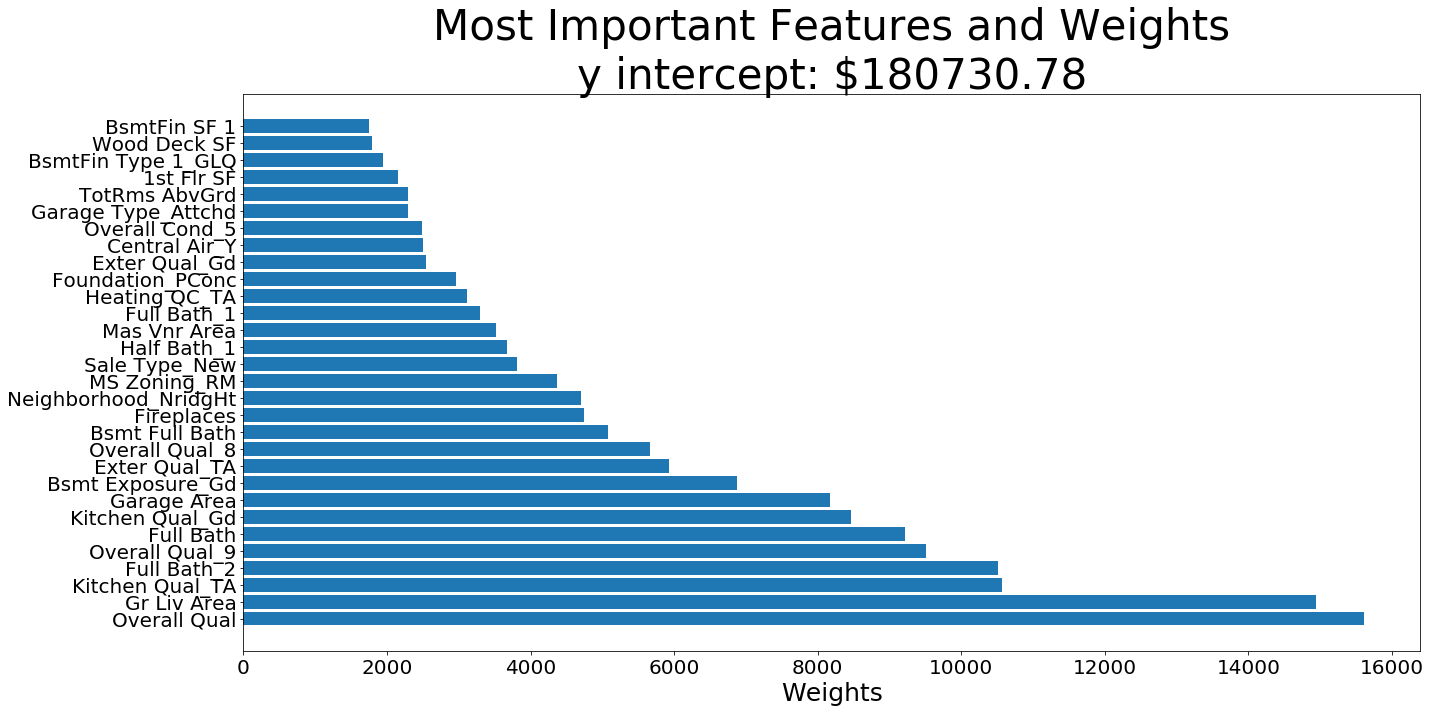

In [14]:
plt.figure(figsize=(20,10))
plt.barh(labels, weights_abs)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=25)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()

# Kaggle

I can fit the model onto the Kaggle data to get ready to submit

In [15]:
kaggle = pd.read_csv('../Data/test.csv', index_col = 'Id')
kaggle_int = kaggle.select_dtypes(include = ['object'])
kaggle_int_d = pd.get_dummies(kaggle_int, drop_first=True)
kaggle.drop(['PID', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'BsmtFin SF 2'], axis=1, inplace=True)
kaggle_con = pd.concat((kaggle, kaggle_int_d), axis=1)
kaggle_con.fillna(0, inplace=True)

In [16]:
# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( kaggle_con.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    kaggle_con[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
kaggle_con = kaggle_con[X_train.columns]

In [17]:
columns = X_train.columns

kaggle_con = kaggle_con[columns]

preds = gs.predict(kaggle_con)

In [18]:
preds = gs.predict(kaggle_con)

In [19]:
submission = pd.DataFrame(preds, index=kaggle.index, columns=['SalePrice'])

In [20]:
submission.sort_index(inplace=True)

In [21]:
submission.head()

,SalePrice
Id,
2,131933.098262
4,271980.551956
6,208056.561889
7,230596.104506
17,220843.148246


In [22]:
submission.to_csv('../Data/numeric_only_ridge.csv')

In [23]:
!head ../Data/numeric_only_ridge.csv

Id,SalePrice
2,131933.0982624241
4,271980.5519559517
6,208056.56188906962
7,230596.10450610128
17,220843.14824576792
18,310305.4986982984
22,226904.6619128571
27,120957.5771125903
31,106962.54858833263


0.8816432832042411


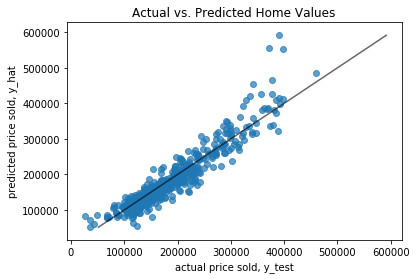

In [24]:
model = gs.score(X_train, y_train)
predicted = gs.predict(X_test)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c = 'k', alpha = .6)
plt.scatter(predicted, y_test, alpha = .7)
plt.xlabel('actual price sold, y_test')
plt.ylabel('predicted price sold, y_hat')
plt.title('Actual vs. Predicted Home Values')

print(gs.score(X_test, y_test))